# Email Delivery Experiment and A/B Testing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime
import random

import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
from dmba import plotDecisionTree

pd.options.display.max_columns = None

## 1. Data Import and Transformation

### 1.1. Segment List

In [2]:
segment_list = pd.read_csv('data/sample_segment_groups.csv')
segment_list.drop(columns='Unnamed: 0', inplace=True)
print(segment_list.info())
segment_list
# note: 'user_uuid' is the count for 'user_uuid'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   group_id                      12 non-null     int64 
 1   approved_within6M_flag        12 non-null     bool  
 2   link_flag                     12 non-null     bool  
 3   recent_activity_flag(20days)  12 non-null     bool  
 4   5day_trade_flag               12 non-null     bool  
 5   user_uuid                     12 non-null     int64 
 6   group_name                    12 non-null     object
dtypes: bool(4), int64(2), object(1)
memory usage: 468.0+ bytes
None


,group_id,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag,user_uuid,group_name
0,0,False,False,False,False,4418550,ML_unfund_exp_control
1,1,False,False,True,False,314921,20D_Act
2,2,False,False,True,True,409786,20D_Act-5D_Act
3,3,False,True,False,False,941341,link
4,4,False,True,True,False,102541,link-20D_Act
5,5,False,True,True,True,136513,link-20D_Act-5D_Act
6,6,True,False,False,False,814827,6M_App
7,7,True,False,True,False,218938,6M_App-20D_Act
8,8,True,False,True,True,233445,6M_App-20D_Act-5D_Act
9,9,True,True,False,False,127008,6M_App-link


### 1.2. Email Template List
- hard code Email lists. Email ID is the index of the Email in the list

In [3]:
PO_number_list = ['ml_funding_enables_investing','ml_investing_starts_here','ml_explore_the_app_investing',
                  'ml_funding_faq','ml_user_clustering_emails_fracs','ml_funding_is_safe','ml_picking_an_investment', 
                  'ml_investing_101','ml_diversified_portfolio','ml_explore_the_app_list']
email_template = pd.Series(PO_number_list)
email_id = pd.Series(range(len(PO_number_list)))
email_template_list = pd.concat([email_id, email_template], axis=1)
email_template_list.columns = ['email_id', 'email_template']
email_template_list

,email_id,email_template
0,0,ml_funding_enables_investing
1,1,ml_investing_starts_here
2,2,ml_explore_the_app_investing
3,3,ml_funding_faq
4,4,ml_user_clustering_emails_fracs
5,5,ml_funding_is_safe
6,6,ml_picking_an_investment
7,7,ml_investing_101
8,8,ml_diversified_portfolio
9,9,ml_explore_the_app_list


### 1.3. Experiment - Email Order
- email delivery schedule table for each user in the experiment
- experiment group - 480,000 approved and unfunded users
- 24 treatments (12 user segments with 2 delivery frequencies)

#### 1.3.1. Email Order

In [4]:
email_order = pd.read_csv('data/sample_uuid_email_order.csv')
print(email_order.info())
email_order.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   user_uuid   480000 non-null  object
 1   group_id    480000 non-null  int64 
 2   group_name  480000 non-null  object
 3   order_0     480000 non-null  int64 
 4   order_1     480000 non-null  int64 
 5   order_2     480000 non-null  int64 
 6   order_3     480000 non-null  int64 
 7   order_4     480000 non-null  int64 
 8   order_5     480000 non-null  int64 
 9   order_6     480000 non-null  int64 
 10  order_7     480000 non-null  int64 
 11  order_8     480000 non-null  int64 
 12  order_9     480000 non-null  int64 
dtypes: int64(11), object(2)
memory usage: 47.6+ MB
None


,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
0,id_2623238174270264636,0,ML_unfund_exp_control_D,5,7,3,4,8,9,0,1,6,2
1,id_14752263936159847779,0,ML_unfund_exp_control_D,3,1,6,0,5,9,4,8,7,2
2,id_3723259155072282145,0,ML_unfund_exp_control_D,8,7,3,6,1,4,2,9,0,5
3,id_9433964625840258739,0,ML_unfund_exp_control_D,1,8,0,6,5,7,4,9,3,2
4,id_17251718038176858460,0,ML_unfund_exp_control_D,6,1,8,0,7,3,5,2,9,4


In [5]:
# check duplicates
# might be a typo, ignore for now
email_order[email_order.duplicated(subset=['user_uuid'], keep=False)]

,user_uuid,group_id,group_name,order_0,order_1,order_2,order_3,order_4,order_5,order_6,order_7,order_8,order_9
140669,id_2680538943028865065,7,link_W,2,7,6,3,8,0,9,5,4,1
152290,id_2680538943028865065,7,link_W,4,7,1,8,5,3,0,6,2,9


#### 1.3.2. Group List with Frequency and Segment Factors (24)

In [6]:
df = email_order[['group_id','group_name']].value_counts().to_frame('count').reset_index().sort_values('group_id')
df = df[['group_id','group_name']]
df['segment'] = df['group_name'].str[:-2]
df['frequency'] = df['group_name'].str[-1:]
df = pd.merge(left=df, right=segment_list, how='inner', left_on='segment', right_on='group_name', suffixes=['', '_right'])
group_list = df[['group_id', 'group_name', 'segment', 'frequency', 'approved_within6M_flag', 'link_flag', 'recent_activity_flag(20days)', '5day_trade_flag']]
group_list

,group_id,group_name,segment,frequency,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag
0,0,ML_unfund_exp_control_D,ML_unfund_exp_control,D,False,False,False,False
1,1,ML_unfund_exp_control_W,ML_unfund_exp_control,W,False,False,False,False
2,2,20D_Act_D,20D_Act,D,False,False,True,False
3,3,20D_Act_W,20D_Act,W,False,False,True,False
4,4,20D_Act-5D_Act_D,20D_Act-5D_Act,D,False,False,True,True
5,5,20D_Act-5D_Act_W,20D_Act-5D_Act,W,False,False,True,True
6,6,link_D,link,D,False,True,False,False
7,7,link_W,link,W,False,True,False,False
8,8,link-20D_Act_D,link-20D_Act,D,False,True,True,False
9,9,link-20D_Act_W,link-20D_Act,W,False,True,True,False


### 1.4. Result Data - Experiment Group
- current account status of users in the experiment

In [7]:
user_event = pd.read_csv('data/user_events.csv')
print(user_event.info())
user_event.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 480000 entries, 0 to 479999
Data columns (total 22 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   user_uuid                        480000 non-null  object 
 1   group_name                       480000 non-null  object 
 2   ml_funding_enables_investing     419714 non-null  object 
 3   ml_investing_starts_here         418640 non-null  object 
 4   ml_explore_the_app_investing     418887 non-null  object 
 5   ml_funding_faq                   418791 non-null  object 
 6   ml_user_clustering_emails_fracs  418404 non-null  object 
 7   ml_funding_is_safe               419259 non-null  object 
 8   ml_picking_an_investment         418819 non-null  object 
 9   ml_investing_101                 418467 non-null  object 
 10  ml_diversified_portfolio         419087 non-null  object 
 11  ml_explore_the_app_list          418288 non-null  object 
 12  ap

,user_uuid,group_name,ml_funding_enables_investing,ml_investing_starts_here,ml_explore_the_app_investing,ml_funding_faq,ml_user_clustering_emails_fracs,ml_funding_is_safe,ml_picking_an_investment,ml_investing_101,ml_diversified_portfolio,ml_explore_the_app_list,approved_at,first_funded_at,first_linked_bank_account_at,5d_trading_avg_event_count,2d_non_trading_avg_event_count,20d_trading_avg_event_count,8d_non_trading_avg_event_count,1d_trading_avg_event_count,1d_non_trading_avg_event_count,num_received_email
0,id_2623238174270264636,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-14 16:31:59.295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,id_14752263936159847779,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,open,delivered,2019-01-29 16:22:26.866,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9
2,id_3723259155072282145,ML_unfund_exp_control_D,delivered,delivered,open,open,open,delivered,delivered,delivered,delivered,open,2019-02-01 00:01:48.853,2020-12-04 20:41:55.146,2020-12-04 20:41:37.842,53.0,NaN,171.0,NaN,NaN,NaN,6
3,id_9433964625840258739,ML_unfund_exp_control_D,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,delivered,2020-03-17 21:02:43.906,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10
4,id_17251718038176858460,ML_unfund_exp_control_D,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-12-30 18:23:15.726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


### 1.5. Result Data - Control Group

- summarized table on the current status for control groups who have not received any emails
- they have the same sagmentation rules in the beginning of the experiment.  

In [8]:
control_group = pd.read_csv('data/control_groups_rate.csv')
control_group['group_name'] = control_group['group_name'].str[:-2]
control_group.rename(columns={'group_name': 'segment'}, inplace=True)
print(control_group.info())
control_group

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   segment                  12 non-null     object 
 1   num_users_in_control     12 non-null     int64  
 2   num_funded_in_control    12 non-null     int64  
 3   funding_rate_in_control  12 non-null     float64
 4   num_link_in_control      12 non-null     int64  
 5   link_rate_in_control     12 non-null     float64
dtypes: float64(2), int64(3), object(1)
memory usage: 708.0+ bytes
None


,segment,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control
0,20D_Act-5D_Act,369786,7802,0.021099,9899,0.026770
1,20D_Act,274921,4053,0.014742,5143,0.018707
2,6M_App-20D_Act-5D_Act,193445,11556,0.059738,13396,0.069250
3,6M_App-20D_Act,178938,5636,0.031497,6570,0.036717
4,6M_App-link-20D_Act-5D_Act,29697,3047,0.102603,29697,1.000000
5,6M_App-link-20D_Act,7883,291,0.036915,7883,1.000000
6,6M_App-link,87008,1072,0.012321,87008,1.000000
7,6M_App,774827,8675,0.011196,10086,0.013017
8,ML_unfund_exp_control,1000000,4443,0.004443,5461,0.005461
9,link-20D_Act-5D_Act,96513,3645,0.037767,96513,1.000000


## 2. Calculation - Email Open Rate

### 2.1. Email Open Rate by Email Template

In [9]:
email_open_rate_by_group_template = pd.DataFrame()

for email_template in email_template_list['email_template']:
    df = pd.pivot_table(user_event[['group_name', email_template]], index=['group_name'], columns=[email_template], aggfunc=len, fill_value=0)
    df['email_template'] = email_template
    df['delivered_count'] = df['delivered'] + df['open']
    df['opened_count'] = df['open']
    df['open_rate'] = round(df['opened_count'] / df['delivered_count'], 4)
    df = df[['email_template', 'delivered_count', 'opened_count', 'open_rate']]
    df.columns.name = None
    df.reset_index(inplace=True)
    email_open_rate_by_group_template = pd.concat([email_open_rate_by_group_template, df], axis=0)

email_open_rate_by_group_template.head()

,group_name,email_template,delivered_count,opened_count,open_rate
0,20D_Act-5D_Act_D,ml_funding_enables_investing,19228,3191,0.1660
1,20D_Act-5D_Act_W,ml_funding_enables_investing,17410,2873,0.1650
2,20D_Act_D,ml_funding_enables_investing,19058,3464,0.1818
3,20D_Act_W,ml_funding_enables_investing,17195,3022,0.1757
4,6M_App-20D_Act-5D_Act_D,ml_funding_enables_investing,19285,3465,0.1797


### 2.2. Email Open Rate by Delivery Day

In [10]:
# define function to get email open rate for specified group and specified day
def get_email_open_rate_by_group_day(group_name, day, email_order, user_event, email_template_list):
    # get data of specified group and specified day
    df = email_order[email_order['group_name'] == group_name][['user_uuid', day]]
    # for each user, get corresponding email_template based on email_id
    df = pd.merge(left=df, right=email_template_list, how='inner', left_on=day, right_on='email_id')[['user_uuid', 'email_template']]
    # for each user, get corresponding email status based on email_template
    df = pd.merge(left=df, right=user_event, how='inner', left_on='user_uuid', right_on='user_uuid')
    df['email_status'] = df.apply(lambda row: row[row['email_template']], axis=1)
    # for each group, calculate email open rate
    email_status_cnt = df['email_status'].value_counts()
    opened_count = email_status_cnt['open'] if 'open' in email_status_cnt.index else 0
    delivered_count = email_status_cnt['delivered'] + opened_count if 'delivered' in email_status_cnt.index else 0
    open_rate = round(opened_count/delivered_count, 4) if delivered_count != 0 else None
    res = pd.Series([group_name, day, delivered_count, opened_count, open_rate], index=['group_name', 'day', 'delivered_count', 'opened_count', 'open_rate'])
    return res

For Daily Groups

In [11]:
# look at only '_D' groups
# get list of groups and days
groups_daily = list(group_list[group_list['group_name'].str[-1] == 'D']['group_name'])
days = ['order_0', 'order_1', 'order_2', 'order_3', 'order_4', 'order_5', 'order_6', 'order_7', 'order_8', 'order_9']
# get result
email_open_rate_by_group_day = pd.DataFrame()
for group_name in groups_daily:
    for day in days:
        row = get_email_open_rate_by_group_day(group_name, day, email_order, user_event, email_template_list)
        email_open_rate_by_group_day = pd.concat([email_open_rate_by_group_day, pd.DataFrame(row).transpose()], axis=0)
email_open_rate_by_group_day.head()

,group_name,day,delivered_count,opened_count,open_rate
0,ML_unfund_exp_control_D,order_0,17010,2569,0.151
0,ML_unfund_exp_control_D,order_1,16926,2642,0.1561
0,ML_unfund_exp_control_D,order_2,16867,2610,0.1547
0,ML_unfund_exp_control_D,order_3,16801,2527,0.1504
0,ML_unfund_exp_control_D,order_4,16717,2533,0.1515


For Weekly Groups

In [12]:
# look at only '_W' groups
groups_weekly = list(group_list[group_list['group_name'].str[-1] == 'W']['group_name'])
days = ['order_0', 'order_1', 'order_2', 'order_3', 'order_4', 'order_5', 'order_6', 'order_7', 'order_8', 'order_9']
# get result
email_open_rate_by_group_day_weekly = pd.DataFrame()
for group_name in groups_weekly:
    for day in days:
        row = get_email_open_rate_by_group_day(group_name, day, email_order, user_event, email_template_list)
        email_open_rate_by_group_day_weekly = pd.concat([email_open_rate_by_group_day_weekly, pd.DataFrame(row).transpose()], axis=0)
email_open_rate_by_group_day_weekly.head()

,group_name,day,delivered_count,opened_count,open_rate
0,ML_unfund_exp_control_W,order_0,16977,2545,0.1499
0,ML_unfund_exp_control_W,order_1,16836,2657,0.1578
0,ML_unfund_exp_control_W,order_2,16454,2586,0.1572
0,ML_unfund_exp_control_W,order_3,16398,2453,0.1496
0,ML_unfund_exp_control_W,order_4,16351,2380,0.1456


## 3. Analysis - Best Email Template to Send

### 3.1. In General

In general, we can clearly see that two email templates perform better based on the open rate
- **template 'ml_funding_faq' ranks the first, with email open rate as 0.2599**
- template 'ml_user_clustering_emails_fracs' ranks the second, with email open rate as 0.1826
- while the open rate is within (0.17, 0.18) for other email templates

In [13]:
def apply_func(df):
    delivered_count = df['delivered_count'].sum()
    opened_count = df['opened_count'].sum()
    open_rate = round(opened_count/delivered_count, 4)
    return pd.Series([delivered_count, opened_count, open_rate], index = ['delivered_count', 'opened_count', 'open_rate'])
email_open_rate_by_template = email_open_rate_by_group_template.groupby('email_template').apply(apply_func).reset_index().sort_values('open_rate', ascending=False)
email_open_rate_by_template

,email_template,delivered_count,opened_count,open_rate
4,ml_funding_faq,418680.0,108794.0,0.2599
9,ml_user_clustering_emails_fracs,418259.0,76385.0,0.1826
8,ml_picking_an_investment,418689.0,74827.0,0.1787
2,ml_explore_the_app_list,418148.0,74365.0,0.1778
5,ml_funding_is_safe,419145.0,74214.0,0.1771
6,ml_investing_101,418326.0,73746.0,0.1763
7,ml_investing_starts_here,418514.0,73455.0,0.1755
3,ml_funding_enables_investing,419579.0,73024.0,0.1740
1,ml_explore_the_app_investing,418772.0,72784.0,0.1738
0,ml_diversified_portfolio,418941.0,72569.0,0.1732


### 3.2. By Segment Group

From the results below, we can get similar conclusions
- **for every segment group, template 'ml_funding_faq' would be the top1 choice**
- the template 'ml_user_clustering_emails_fracs' can be the top2 choice for many segment groups
- for each group, the top2 and top3 template choices can vary, see below

In [14]:
def apply_func(df):
    df = df.sort_values('open_rate', ascending=False).head(3)
    top3 = list(df['email_template'] + ' (' + df['open_rate'].astype(str) + ')')
    return pd.Series(top3, index=['EmailTemplateTop1', 'EmailTemplateTop2', 'EmailTemplateTop3'])  
df = email_open_rate_by_group_template.groupby('group_name').apply(apply_func).reset_index()
df

,group_name,EmailTemplateTop1,EmailTemplateTop2,EmailTemplateTop3
0,20D_Act-5D_Act_D,ml_funding_faq (0.2626),ml_user_clustering_emails_fracs (0.177),ml_picking_an_investment (0.1717)
1,20D_Act-5D_Act_W,ml_funding_faq (0.2625),ml_user_clustering_emails_fracs (0.1802),ml_picking_an_investment (0.1688)
2,20D_Act_D,ml_funding_faq (0.2681),ml_user_clustering_emails_fracs (0.1916),ml_picking_an_investment (0.1861)
3,20D_Act_W,ml_funding_faq (0.2688),ml_explore_the_app_list (0.1855),ml_user_clustering_emails_fracs (0.1845)
4,6M_App-20D_Act-5D_Act_D,ml_funding_faq (0.2539),ml_user_clustering_emails_fracs (0.1918),ml_picking_an_investment (0.1891)
5,6M_App-20D_Act-5D_Act_W,ml_funding_faq (0.257),ml_user_clustering_emails_fracs (0.1939),ml_investing_starts_here (0.1886)
6,6M_App-20D_Act_D,ml_funding_faq (0.2513),ml_user_clustering_emails_fracs (0.2009),ml_picking_an_investment (0.2005)
7,6M_App-20D_Act_W,ml_funding_faq (0.2544),ml_user_clustering_emails_fracs (0.1927),ml_explore_the_app_list (0.186)
8,6M_App-link-20D_Act-5D_Act_D,ml_funding_faq (0.3154),ml_user_clustering_emails_fracs (0.2153),ml_funding_is_safe (0.2053)
9,6M_App-link-20D_Act-5D_Act_W,ml_funding_faq (0.3155),ml_user_clustering_emails_fracs (0.2043),ml_picking_an_investment (0.2027)


## 4. Analysis - Best Delivery Day to Send

- For both daily and weekly groups, the **highest email open rate (peak)** happens approximately on the **second time of sending emails**, which is **Day_1 for daily groups** and **Day_4 for weekly groups**; and the email open rate **keeps at a high level during the first three times of sending emails**
- As for the email delivery strategy, we would **prefer sending emails for the first three days/times** in order to let more users open the email
- Also, based on the current data, we can see that the experiment has completely finished yet.  If we look at the Day_32 (last day) of the weekly groups, there are no observed data for delivered or opened emails, which means that we have not gathered all the result data yet

### 4.1. Daily Groups Time Series Analysis

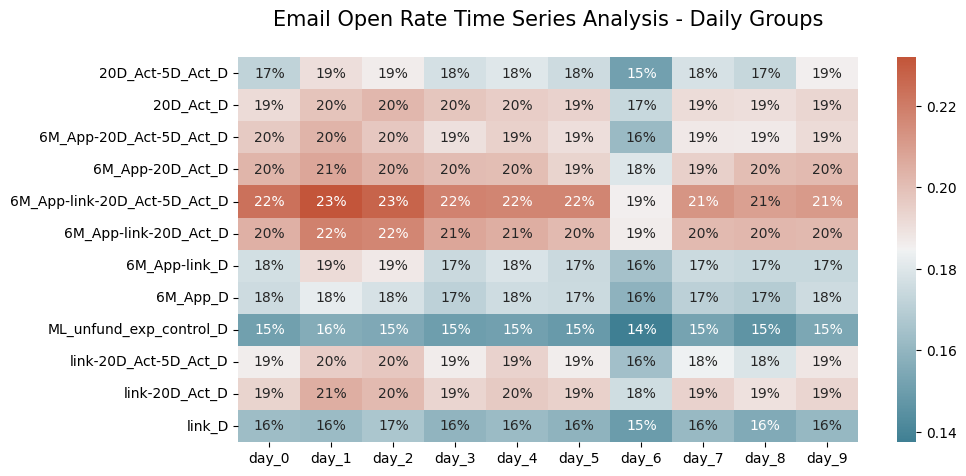

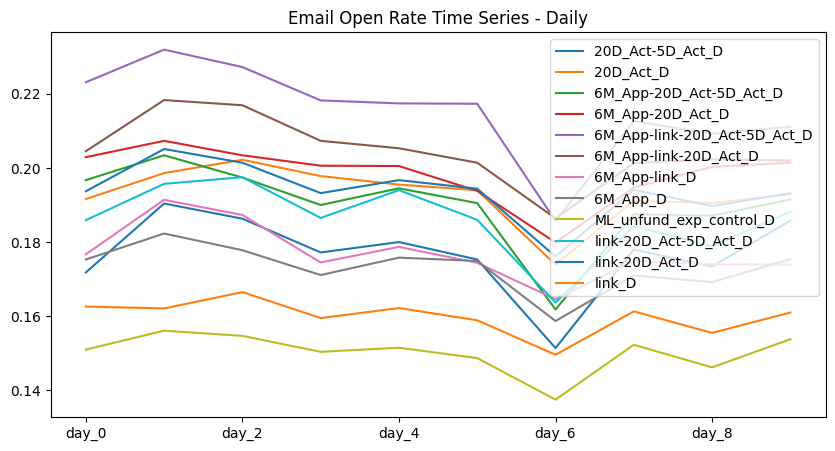

In [15]:
# for each group, look at the trend of email open rate as time goes by
df_daily = pd.pivot_table(email_open_rate_by_group_day, index=['group_name'], columns=['day'], values='open_rate')
df_daily.columns = ['day_0', 'day_1', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9']
# plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df_daily, annot=True, fmt='.0%', cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax)
ax.set_title('Email Open Rate Time Series Analysis - Daily Groups\n', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('')

# plot time series
fig, ax = plt.subplots(figsize=(10, 5))
df_daily.T.plot(ax=ax)
ax.set_title('Email Open Rate Time Series - Daily')
ax.legend(loc = 'upper right')

### 4.2. Weekly Groups Time Series Analysis

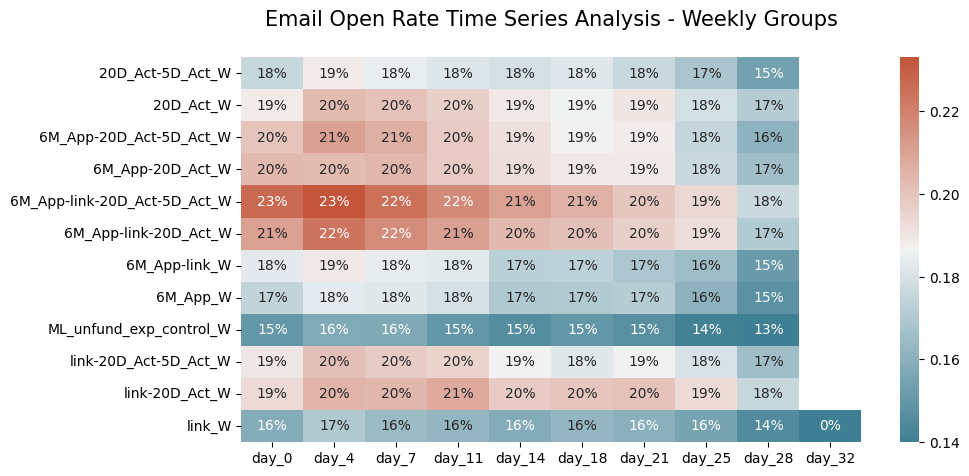

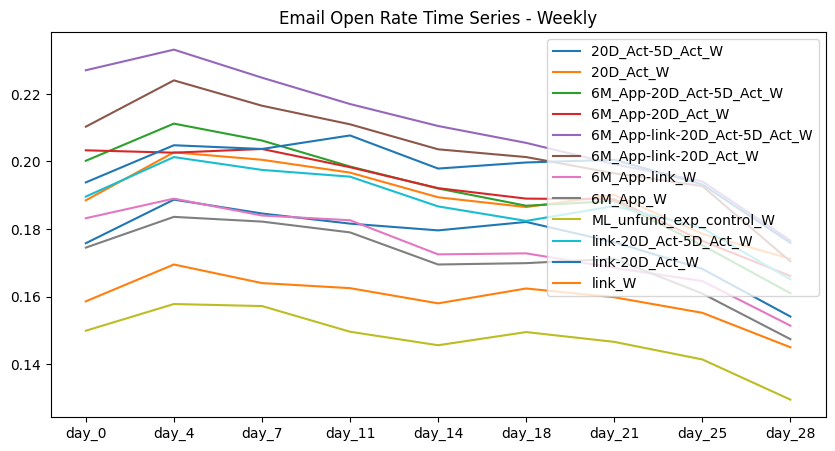

In [16]:
df_weekly = pd.pivot_table(email_open_rate_by_group_day_weekly, index=['group_name'], columns=['day'], values='open_rate')
df_weekly.columns = ['day_0', 'day_4', 'day_7', 'day_11', 'day_14', 'day_18', 'day_21', 'day_25', 'day_28', 'day_32']
# plot
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(df_weekly, annot=True, fmt='.0%', cmap=sns.diverging_palette(220, 20, as_cmap=True), ax=ax, vmin=0.14)
ax.set_title('Email Open Rate Time Series Analysis - Weekly Groups\n', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('')

# plot time series
fig, ax = plt.subplots(figsize=(10, 5))
df_weekly.T[:-1].plot(ax=ax)
ax.set_title('Email Open Rate Time Series - Weekly')
ax.legend(loc = 'upper right')

## 5. Statistical Modeling - Email Open Rate Prediction and Factors Deep Dive

**What are important user segment factors that correlate to email open rate?**

**How to predict email open rate using user segment factors?**

### 5.1. Linear Regression

- As seen from the linear regression result, **recent_activity_flag(20days)** and **approved_within6M_flag** are the most important factors that correlate to email open rate; these two factors are significant (**p-value < 0.05**) in both simple and multiple linear regressions
- Both of them have **positive coefficient**, which means the email open rate can be higher if there are activities in the recent 20 days (active users) or the account is approved within 6 months (new users)
- **recent_activity_flag(20days)** is the most correlated factor to the email open rate, as it can individually explains **64.7% (R-squared)** of the total variance of the email open rate, which is shown in the simple linear regression

In [17]:
# get email open rate and segment factors for each group
def apply_func(df):
    delivered_count = df['delivered_count'].sum()
    opened_count = df['opened_count'].sum()
    open_rate = round(opened_count/delivered_count, 4)
    return pd.Series([delivered_count, opened_count, open_rate], index=['delivered_count', 'opened_count', 'open_rate'])
df = email_open_rate_by_group_template.groupby('group_name').apply(apply_func).reset_index()
df = df.astype({'delivered_count': 'int32', 'opened_count': 'int32'})
df = pd.merge(left=df, right=group_list, how='inner', left_on='group_name', right_on='group_name')
email_open_rate_by_group = df.drop(columns=['group_id', 'segment'])
email_open_rate_by_group.head(3)

,group_name,delivered_count,opened_count,open_rate,frequency,approved_within6M_flag,link_flag,recent_activity_flag(20days),5day_trade_flag
0,20D_Act-5D_Act_D,192450,34060,0.1770,D,False,False,True,True
1,20D_Act-5D_Act_W,173261,30632,0.1768,W,False,False,True,True
2,20D_Act_D,190464,36730,0.1928,D,False,False,True,False


In [18]:
# look at regression result for individual feature
features = ['frequency', 'approved_within6M_flag', 'link_flag', 'recent_activity_flag(20days)', '5day_trade_flag']
for feature in features:
    X = pd.get_dummies(email_open_rate_by_group[feature], drop_first=True).astype('int') # convert categorical features
    y = email_open_rate_by_group['open_rate']
    X_model = sm.add_constant(X.values)
    results = sm.OLS(y.values, X_model).fit()
    print('\nfeature name: {}, p-value: {}, R-squared: {}'.format(feature, round(results.pvalues[1], 3), round(results.rsquared, 3)))


feature name: frequency, p-value: 0.822, R-squared: 0.002

feature name: approved_within6M_flag, p-value: 0.035, R-squared: 0.186

feature name: link_flag, p-value: 0.173, R-squared: 0.083

feature name: recent_activity_flag(20days), p-value: 0.0, R-squared: 0.647

feature name: 5day_trade_flag, p-value: 0.142, R-squared: 0.095


In [19]:
# look at all features
predictors = ['frequency', 'approved_within6M_flag', 'link_flag', 'recent_activity_flag(20days)', '5day_trade_flag']
outcome = 'open_rate'
X = pd.get_dummies(email_open_rate_by_group[predictors], drop_first=True).astype('int') # convert categorical features
print('feature names: \n', list(X.columns))
y = email_open_rate_by_group[outcome]
# fit the model
model = sm.OLS(y.values, sm.add_constant(X.values))
results = model.fit()
results.summary()

feature names: 
 ['approved_within6M_flag', 'link_flag', 'recent_activity_flag(20days)', '5day_trade_flag', 'frequency_W']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     47.65
Date:                Tue, 28 May 2024   Prob (F-statistic):           9.31e-10
Time:                        12:12:48   Log-Likelihood:                 94.889
No. Observations:                  24   AIC:                            -177.8
Df Residuals:                      18   BIC:                            -170.7
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1524      0.003     56.884      0.000       0.147       0.158
x1             0.0151      0.002      6.908      0.000       0.011       0.020
x2             0.0101      0.002      4.601      0.000       0.005       0.015
x3             0.0322      0.003     12.015      0.000       0.027       0.038
x4            -0.0046      0.003     -1.730      0.101      -0.010       0.001
x5            -0.0017      0.002     -0.777      0.447      -0.006       0.003
==============================================================================
Omnibus:                        2.865   Durbin-Watson:                   1.791
Prob(Omnibus):                  0.239   Jarque-Bera (JB):                2.445
Skew:                           0.706   Prob(JB):                        0.295
Kurtosis:                       2.329   Cond. No.                         5.17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 5.2. Decision Tree

The training r2_score is: 0.9712
The testing r2_score is: 0.8536


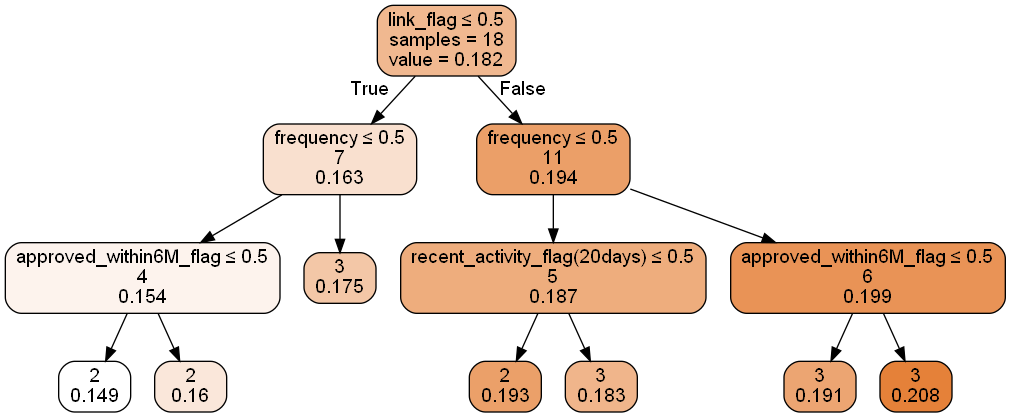

In [20]:
# fit the model
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)
tree = DecisionTreeRegressor(random_state=1, criterion='squared_error', min_samples_leaf=2)
tree.fit(X_train, y_train)
print('The training r2_score is: {:.4f}'.format(r2_score(y_train, tree.predict(X_train))))
print('The testing r2_score is: {:.4f}'.format(r2_score(y_test, tree.predict(X_test))))
# plot the decision rules
plotDecisionTree(tree, feature_names=predictors)

Text(0, 0.5, '')

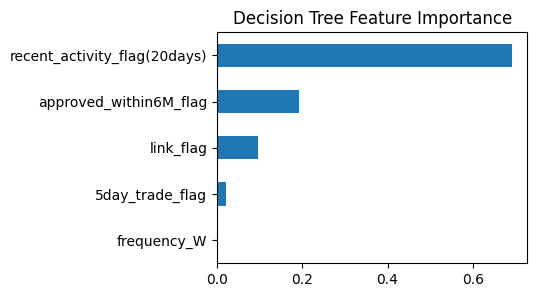

In [21]:
df = pd.DataFrame()
df['Feature'] = tree.feature_names_in_
df['Importance'] = tree.feature_importances_
df.sort_values('Importance', inplace=True)
ax = df.plot(kind='barh', x='Feature', y='Importance', legend=False, figsize=(4, 3))
ax.set_title('Decision Tree Feature Importance')
ax.set_ylabel('')

### 5.3. PCA - Principal Component Analysis

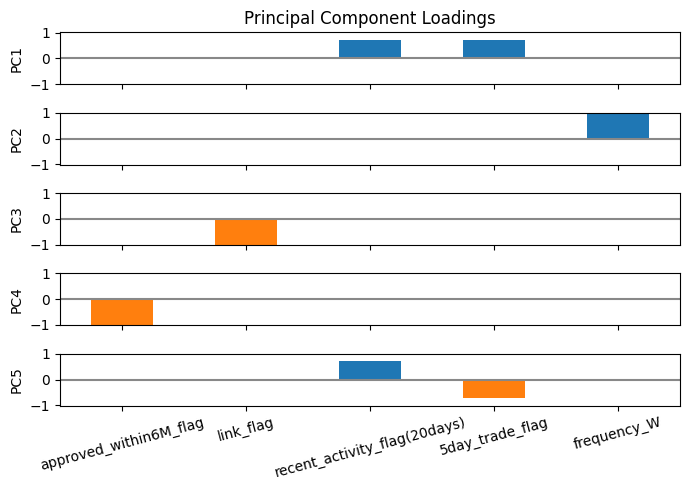

In [22]:
pca = PCA(n_components=5)
pca.fit(X)
loadings = pd.DataFrame(pca.components_, columns=X.columns)
# plot loadings for each principal component
pc_max = 1.01 * loadings.loc[0:5, :].abs().to_numpy().max()
f, axes = plt.subplots(5, 1, figsize=(7, 5), sharex=True)
for i, ax in enumerate(axes):
    if i == 0:
        ax.set_title('Principal Component Loadings')
    pc_loadings = loadings.loc[i, :]
    pc_loadings.plot.bar(ax=ax, color=['C0' if loading > 0 else 'C1' for loading in pc_loadings])
    ax.axhline(0, color='#888888')
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-pc_max, pc_max)
plt.xticks(rotation=15)
plt.tight_layout()

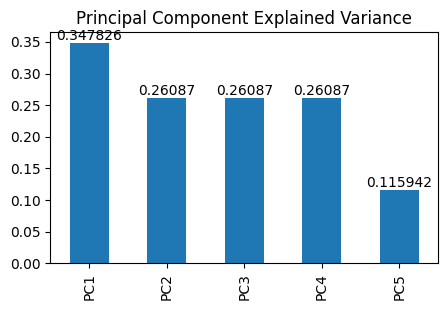

In [23]:
df = pd.DataFrame()
df['Principal Component'] = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
df['Explained Variance'] = pca.explained_variance_
ax = df.plot.bar(x='Principal Component', y='Explained Variance', legend=False, figsize=(5, 3))
ax.set_title('Principal Component Explained Variance')
ax.set_xlabel('')
ax.bar_label(ax.containers[0])
plt.show()

## 6. Calculation - Link and Funding Rate 

- The link rate and funding rate for each experiment group are listed in the result table below
- The calculation is conducted after removing users that have not received any emails

In [24]:
# remove users that have not received any emails; status is not 'delivered' or 'open'
email_templates = list(email_template_list['email_template'])

def apply_func(row):
    delivered_flag = False
    for email_template in email_templates:
        if row[email_template] == 'delivered' or row[email_template] == 'open':
            delivered_flag = True
    return delivered_flag

user_event_delivered = user_event[user_event.apply(apply_func, axis=1)]

In [25]:
# calculate the link and funding rate for each experiment group
def apply_func(df):
    num_users = len(df)
    num_funded = df['first_funded_at'].notnull().sum()
    funding_rate = round(num_funded/num_users, 6)
    num_link = df['first_linked_bank_account_at'].notnull().sum()
    link_rate = round(num_link/num_users, 6)
    return pd.Series([num_users, num_funded, funding_rate, num_link, link_rate]
                     , index=['num_users_in_exp', 'num_funded_in_exp', 'funding_rate_in_exp', 'num_link_in_exp', 'link_rate_in_exp'])  

df = user_event_delivered.groupby('group_name').apply(apply_func).reset_index()
experiment_group = df.astype({'num_users_in_exp': 'int32', 'num_funded_in_exp': 'int32', 'num_link_in_exp': 'int32'})
experiment_group

,group_name,num_users_in_exp,num_funded_in_exp,funding_rate_in_exp,num_link_in_exp,link_rate_in_exp
0,20D_Act-5D_Act_D,19468,442,0.022704,575,0.029536
1,20D_Act-5D_Act_W,19466,441,0.022655,545,0.027998
2,20D_Act_D,19340,340,0.017580,442,0.022854
3,20D_Act_W,19319,293,0.015166,372,0.019256
4,6M_App-20D_Act-5D_Act_D,19539,1230,0.062951,1431,0.073238
5,6M_App-20D_Act-5D_Act_W,19589,1239,0.063250,1438,0.073409
6,6M_App-20D_Act_D,19380,671,0.034623,769,0.039680
7,6M_App-20D_Act_W,19424,630,0.032434,742,0.038200
8,6M_App-link-20D_Act-5D_Act_D,19565,2103,0.107488,19565,1.000000
9,6M_App-link-20D_Act-5D_Act_W,19587,2084,0.106397,19587,1.000000


## 7. Hypothesis Testing - A/B Testing

#### Does sending emails actually cause a higher **funding rate**?

- Based on the **significant test**, there are **11 groups** have **statistically significant (p-value < 0.05) lift in funding rate** among all 24 groups, which means **sending emails does cause a higher funding rate for these groups**
- Among 11 groups which have significant lift in funding rate, 3 of them have highest lift which are '**ML_unfund_exp_control_D(41.41% lift)**', '**link_D(21.91% lift)**', and '**20D_Act_D(19.25% lift)**'; the **permutation test** for these 3 groups provides similar significant results while the p-values can be slightly different

In [26]:
df = experiment_group
df['segment'] = df['group_name'].str[:-2]
ab_testing = pd.merge(left=df, right=control_group, how='inner', left_on='segment', right_on='segment')
ab_testing.head()

,group_name,num_users_in_exp,num_funded_in_exp,funding_rate_in_exp,num_link_in_exp,link_rate_in_exp,segment,num_users_in_control,num_funded_in_control,funding_rate_in_control,num_link_in_control,link_rate_in_control
0,20D_Act-5D_Act_D,19468,442,0.022704,575,0.029536,20D_Act-5D_Act,369786,7802,0.021099,9899,0.026770
1,20D_Act-5D_Act_W,19466,441,0.022655,545,0.027998,20D_Act-5D_Act,369786,7802,0.021099,9899,0.026770
2,20D_Act_D,19340,340,0.017580,442,0.022854,20D_Act,274921,4053,0.014742,5143,0.018707
3,20D_Act_W,19319,293,0.015166,372,0.019256,20D_Act,274921,4053,0.014742,5143,0.018707
4,6M_App-20D_Act-5D_Act_D,19539,1230,0.062951,1431,0.073238,6M_App-20D_Act-5D_Act,193445,11556,0.059738,13396,0.069250


### 7.1. Significant Test

In [27]:
def ab_testing_funding(row):
    # calculate observed difference and lift
    observed_difference = round(row['funding_rate_in_exp'] - row['funding_rate_in_control'], 4)
    lift = round(((row['funding_rate_in_exp'] - row['funding_rate_in_control']) / row['funding_rate_in_control'] * 100), 2) # percent
    # A/B testing
    alpha = 0.05 # significance level
    count = np.array([row['num_funded_in_exp'], row['num_funded_in_control']])
    nobs = np.array([row['num_users_in_exp'], row['num_users_in_control']])
    stat, pval = proportions_ztest(count, nobs, alternative='larger')
    significance = True if pval < alpha else False
    return pd.Series([row['group_name'], round(row['funding_rate_in_exp'], 4), round(row['funding_rate_in_control'], 4), observed_difference, lift, round(pval, 4), significance]
              , index=['group_name', 'funding_rate_in_exp', 'funding_rate_in_control', 'observed_difference', 'lift(%)', 'pval', 'significance'])

print('\nA/B Testing Result for Funding Rate')
print('\n------------------------------------------------------------------------------------')
ab_testing.apply(ab_testing_funding, axis=1).sort_values(['significance', 'lift(%)'], ascending=[False, False])


A/B Testing Result for Funding Rate

------------------------------------------------------------------------------------


,group_name,funding_rate_in_exp,funding_rate_in_control,observed_difference,lift(%),pval,significance
16,ML_unfund_exp_control_D,0.0063,0.0044,0.0018,41.41,0.0002,True
22,link_D,0.0078,0.0064,0.0014,21.91,0.0093,True
2,20D_Act_D,0.0176,0.0147,0.0028,19.25,0.0008,True
14,6M_App_D,0.0128,0.0112,0.0016,14.08,0.0223,True
15,6M_App_W,0.0126,0.0112,0.0014,12.58,0.0361,True
10,6M_App-link-20D_Act_D,0.0414,0.0369,0.0045,12.26,0.0420,True
21,link-20D_Act_W,0.0245,0.0222,0.0023,10.27,0.0317,True
6,6M_App-20D_Act_D,0.0346,0.0315,0.0031,9.92,0.0092,True
5,6M_App-20D_Act-5D_Act_W,0.0633,0.0597,0.0035,5.88,0.0243,True
4,6M_App-20D_Act-5D_Act_D,0.0630,0.0597,0.0032,5.38,0.0358,True


### 7.2. Permutation Test

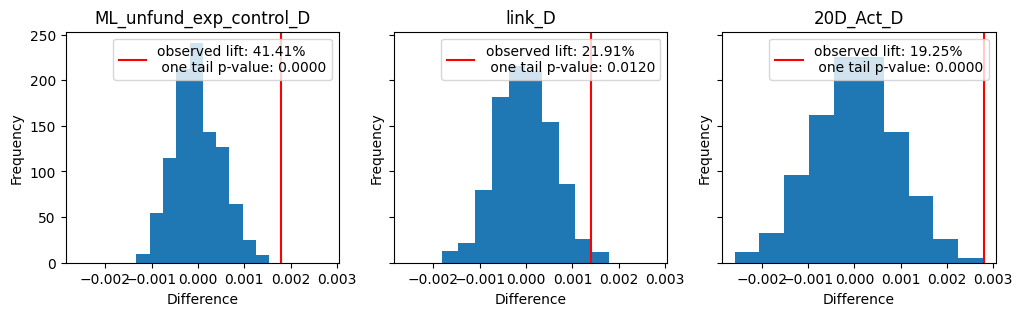

In [28]:
def permutation(x, y):
    xy = np.concatenate((x, y), axis=0) # combined two samples
    nx, nxy = len(x), len(xy)
    idx_x = set(random.sample(range(nxy), nx)) # shuffle and resample
    idx_y = set(range(nxy)) - idx_x
    return xy[list(idx_x)].mean() - xy[list(idx_y)].mean() # resampled statistic

def permutation_test_funding(row, ax):
    # get data
    group_name = row['group_name']
    x = [1] * row['num_funded_in_exp']
    x.extend([0] * (row['num_users_in_exp'] - row['num_funded_in_exp']))
    y = [1] * row['num_funded_in_control']
    y.extend([0] * (row['num_users_in_control'] - row['num_funded_in_control']))
    x, y = np.array(x), np.array(y)
    # calculate observed difference and lift
    observed_difference = round(row['funding_rate_in_exp'] - row['funding_rate_in_control'], 4)
    lift = round(((row['funding_rate_in_exp'] - row['funding_rate_in_control']) / row['funding_rate_in_control'] * 100), 2) # percent
    # permutation distribution of resampled statistic
    diffs = np.array([permutation(x, y) for _ in range(1000)])
    # p-value
    p_value = (diffs >= observed_difference).mean()
    # plot
    ax.hist(diffs)
    ax.set_xlabel('Difference')
    ax.set_ylabel('Frequency')
    ax.set_title(group_name)
    ax.axvline(observed_difference, color='r', label='observed lift: {}%\n one tail p-value: {:.4f}'.format(lift, p_value))
    ax.legend(loc='upper right') 

fig, axes = plt.subplots(1, 3, figsize=(12, 3), sharex=True,sharey=True)
top3_groups = ['ML_unfund_exp_control_D', 'link_D', '20D_Act_D']
for i, group_name in enumerate(top3_groups):
    row = ab_testing[ab_testing['group_name'] == group_name].iloc[0, :]
    permutation_test_funding(row, axes[i])